In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

# Data Import
PREFIX = '05c_'
Delta_LumA = pd.read_csv(f"../Outputs/{PREFIX}Delta_est_LumA.csv", index_col=0)
Delta_LumB = pd.read_csv(f"../Outputs/{PREFIX}Delta_est_LumB.csv", index_col=0)
Delta_Her2 = pd.read_csv(f"../Outputs/{PREFIX}Delta_est_Her2.csv", index_col=0)
Delta_Basal = pd.read_csv(f"../Outputs/{PREFIX}Delta_est_Basal.csv", index_col=0)

In [2]:
# Do this across all 4 subtypes: unstack all, concat, and get the top 20 entries

# Dictionary of all subtypes
# Standardize Delta values (min-max normalization to [0, 1]) before further processing
deltas = {}
for name, df in {
    "LumA": Delta_LumA,
    "LumB": Delta_LumB,
    "Her2": Delta_Her2,
    "Basal": Delta_Basal
}.items():
    df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
    deltas[name] = df_norm

# Unstack and add multiindex for subtype
unstacked_list = []
for subtype, df in deltas.items():
    d = df.unstack()
    d.index = pd.MultiIndex.from_tuples(
        [(subtype, col, idx) for (col, idx) in d.index],
        names=["Subtype", "CellType", "Gene"]
    )
    unstacked_list.append(d)

# Concatenate all and get top 20
all_unstacked = pd.concat(unstacked_list)
top_20 = all_unstacked.sort_values(ascending=False).head(100)
bot_20 = all_unstacked.sort_values(ascending=True).head(100)

# Print (Subtype, CellType, Gene) and value
top_genes = []
print("top genes")
for (subtype, col, idx), value in top_20.items():
    print(f"Subtype: {subtype} | Cell Type: {col} | Gene: {idx} | Value: {value}")
    top_genes.append(idx)

bot_genes = []
print("bot genes")
for (subtype, col, idx), value in bot_20.items():
    print(f"Subtype: {subtype} | Cell Type: {col} | Gene: {idx} | Value: {value}")
    bot_genes.append(idx)


top genes
Subtype: Her2 | Cell Type: B cell | Gene: IGHG1 | Value: 1.0
Subtype: Basal | Cell Type: B cell | Gene: IGHG1 | Value: 1.0
Subtype: LumA | Cell Type: Fibroblast | Gene: AKR1C1 | Value: 1.0
Subtype: LumB | Cell Type: CD4 T cell | Gene: DHRS2 | Value: 1.0
Subtype: LumA | Cell Type: Endothelial cell | Gene: IFI6 | Value: 0.9941689496225227
Subtype: Basal | Cell Type: Fibroblast | Gene: MEG8 | Value: 0.8533911644028608
Subtype: LumA | Cell Type: Myeloid cell | Gene: TPSAB1 | Value: 0.8517917991556844
Subtype: LumA | Cell Type: NK cell | Gene: SLC39A6 | Value: 0.7798983923981394
Subtype: LumA | Cell Type: Endothelial cell | Gene: MT1G | Value: 0.707337493649601
Subtype: Basal | Cell Type: Fibroblast | Gene: EGFR | Value: 0.7058009565585938
Subtype: LumA | Cell Type: Perivascular cell | Gene: IGFBP5 | Value: 0.6813503630381383
Subtype: LumA | Cell Type: Endothelial cell | Gene: IFITM1 | Value: 0.6467793015344437
Subtype: Basal | Cell Type: Fibroblast | Gene: MEG3 | Value: 0.5960296

In [3]:
# Keep unique genes, preserving first occurrence order
unique_top_genes = []
seen = set()
for g in top_genes:
    if g not in seen:
        unique_top_genes.append(g)
        seen.add(g)
#unique_top_genes[0:20]

unique_bot_genes = []
seen = set()
for g in bot_genes:
    if g not in seen:
        unique_bot_genes.append(g)
        seen.add(g)
#unique_bot_genes[0:20]

top 20 upregulated genes


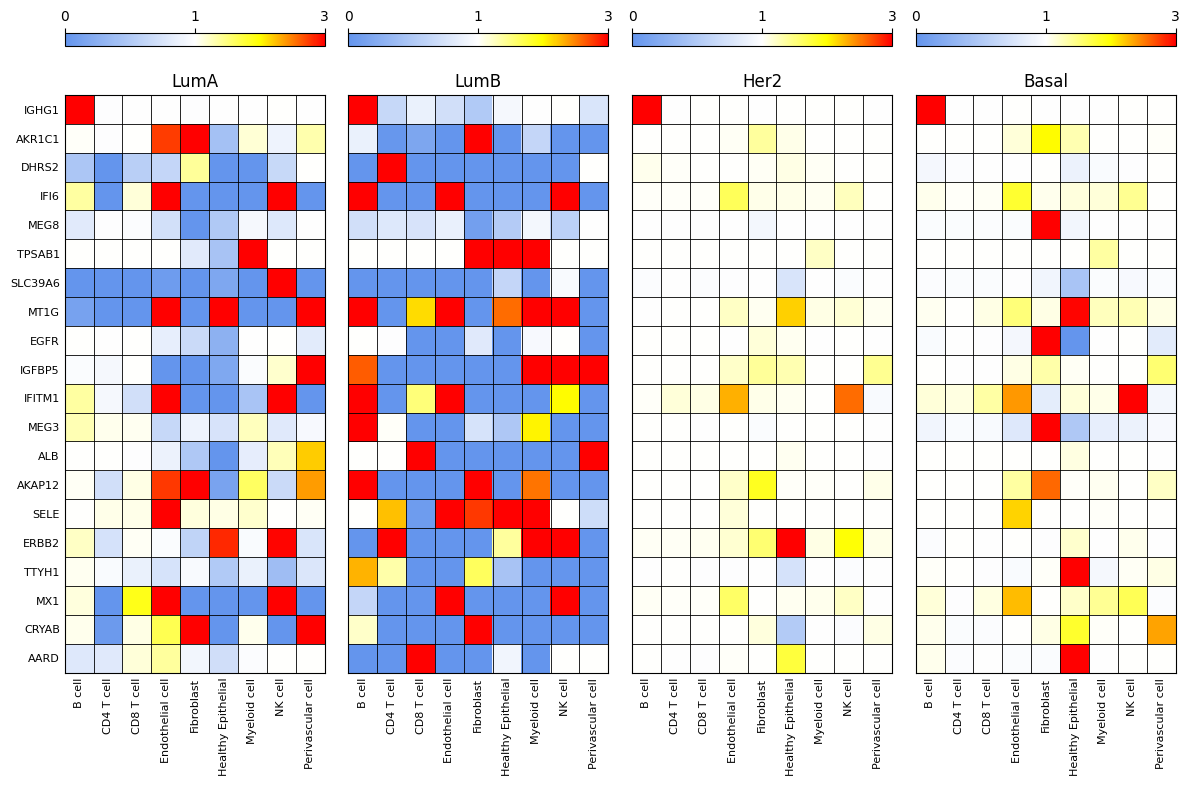

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(12, 10), sharey=True)







subtypes = ["LumA", "LumB", "Her2", "Basal"]
delta_dfs = [Delta_LumA, Delta_LumB, Delta_Her2, Delta_Basal]

for i, (subtype, delta_df) in enumerate(zip(subtypes, delta_dfs)):
    max_delta = delta_df.max().max()
    # Define a colormap:
    # white at value 1 (midpoint), blue at value 0 (min), red at max value
    # To ensure "white" is at value 1 and not at fraction 1/max_delta,
    # and that the colormap midpoint matches value=1 in the data, use TwoSlopeNorm.
    from matplotlib.colors import TwoSlopeNorm

    data = delta_df.loc[unique_top_genes[0:20], :]
    vmin = data.min().min()
    vmax = data.max().max()
    # set midpoint at 1 (delta of 1 means "no change" in ratio, i.e. white)
    #norm = TwoSlopeNorm(vmin=0.0, vcenter=1, vmax=vmax)
    norm = TwoSlopeNorm(vmin=0.0, vcenter=1, vmax=3.0)
    cmap = LinearSegmentedColormap.from_list(
        "blue_white_orange",
        [
            (0.0, "cornflowerblue"),     # color at value 0 (absolute, not relative minimum)
            (0.5, "white"),
            (0.75, 'yellow'),
            (1, "red")    # maximum value
        ]
    )
    im = axs[i].imshow(data, cmap=cmap, norm=norm, aspect='equal')
    # Add black grid lines as borders around each square
    # Grid lines exactly on pixel boundaries for tight fit
    axs[i].set_xticks(np.arange(data.shape[1]+1)-0.5, minor=True)
    axs[i].set_yticks(np.arange(data.shape[0]+1)-0.5, minor=True)
    axs[i].grid(which="minor", color="black", linewidth=0.6)
    axs[i].set_title(subtype)
    axs[i].set_xticks(range(len(delta_df.columns)))
    axs[i].set_xticklabels(delta_df.columns, rotation=90, fontsize=8)
    axs[i].set_yticks(range(20))
    axs[i].tick_params(axis='x', which='both', length=0)
    axs[i].tick_params(axis='y', which='both', length=0)
    axs[i].set_yticklabels(unique_top_genes[0:20], fontsize=8)
   
for i in range(4):
    fig.colorbar(
        axs[i].images[0], 
        ax=axs[i], 
        orientation='horizontal', 
        fraction=0.08,  # slightly wider for horizontal cb
        pad=0.05,       # increase pad to move cb below title but above axis
        location="top",
        #ticks=[0.0, 1.0, round(delta_dfs[i].loc[unique_top_genes[0:20], :].max().max(), 2)]  # ticks at min, 1, and max value (rounded)
        ticks=[0.0, 1.0, 3.0]
    )   

#fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
plt.tight_layout()
plt.savefig("../Outputs/Figure_4_TCGA_heatmap_upregulated.png", dpi=300)
print("top 20 upregulated genes")
plt.show()

top 20 downregulated genes


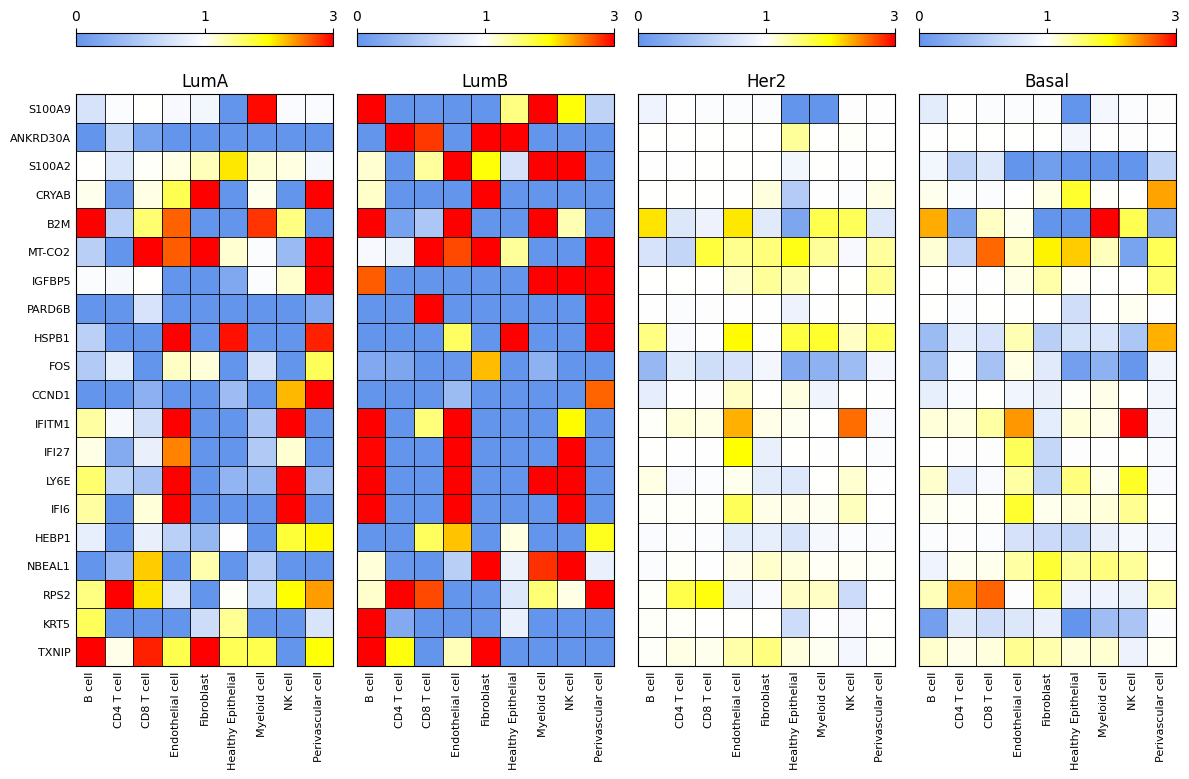

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(12, 10), sharey=True)


subtypes = ["LumA", "LumB", "Her2", "Basal"]
delta_dfs = [Delta_LumA, Delta_LumB, Delta_Her2, Delta_Basal]

for i, (subtype, delta_df) in enumerate(zip(subtypes, delta_dfs)):
    max_delta = delta_df.max().max()
    # Define a colormap:
    # white at value 1 (midpoint), blue at value 0 (min), red at max value
    # To ensure "white" is at value 1 and not at fraction 1/max_delta,
    # and that the colormap midpoint matches value=1 in the data, use TwoSlopeNorm.
    from matplotlib.colors import TwoSlopeNorm

    data = delta_df.loc[unique_bot_genes[0:20], :]
    vmin = data.min().min()
    vmax = data.max().max()
    # set midpoint at 1 (delta of 1 means "no change" in ratio, i.e. white)
    #norm = TwoSlopeNorm(vmin=0.0, vcenter=1, vmax=vmax)
    norm = TwoSlopeNorm(vmin=0.0, vcenter=1, vmax=3.0)
    cmap = LinearSegmentedColormap.from_list(
        "blue_white_orange",
        [
            (0.0, "cornflowerblue"),     # color at value 0 (absolute, not relative minimum)
            (0.5, "white"),
            (0.75, 'yellow'),
            (1, "red")    # maximum value
        ]
    )
    im = axs[i].imshow(data, cmap=cmap, norm=norm, aspect='equal')
    # Add black grid lines as borders around each square
    # Grid lines exactly on pixel boundaries for tight fit
    axs[i].set_xticks(np.arange(data.shape[1]+1)-0.5, minor=True)
    axs[i].set_yticks(np.arange(data.shape[0]+1)-0.5, minor=True)
    axs[i].grid(which="minor", color="black", linewidth=0.6)
    axs[i].set_title(subtype)
    axs[i].set_xticks(range(len(delta_df.columns)))
    axs[i].set_xticklabels(delta_df.columns, rotation=90, fontsize=8)
    axs[i].set_yticks(range(20))
    axs[i].tick_params(axis='x', which='both', length=0)
    axs[i].tick_params(axis='y', which='both', length=0)
    axs[i].set_yticklabels(unique_bot_genes[0:20], fontsize=8)
   
for i in range(4):
    fig.colorbar(
        axs[i].images[0], 
        ax=axs[i], 
        orientation='horizontal', 
        fraction=0.08,  # slightly wider for horizontal cb
        pad=0.05,       # increase pad to move cb below title but above axis
        location="top",
        #ticks=[0.0, 1.0, round(delta_dfs[i].loc[unique_bot_genes[0:20], :].max().max(), 2)]  # ticks at min, 1, and max value (rounded)
        ticks=[0.0, 1.0, 3.0]
    )

#fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
plt.tight_layout()
plt.savefig("../Outputs/Figure_4_TCGA_heatmap_downregulated.png", dpi=300)
print("top 20 downregulated genes")
plt.show()

In [6]:
# Calculate for each subtype the top 20 genes (by max value across all columns), regardless of celltype, and save each as a set in a dict keyed by subtype name

n = 20
subtype_names = ['LumA', 'LumB', 'Her2', 'Basal']
top20_genes_dict = {}
for subtype, delta_df in zip(subtype_names, delta_dfs):
    top20 = delta_df.max(axis=1).sort_values(ascending=False).head(n).index
    top20_genes_dict[subtype] = set(top20)

LumA = top20_genes_dict["LumA"]
LumB = top20_genes_dict["LumB"]
Her2 = top20_genes_dict["Her2"]
Basal = top20_genes_dict["Basal"]

all_genes = LumA.union(LumB).union(Her2).union(Basal)
membership={}
for g in all_genes:
    code = (
        ('1' if g in LumA else '0') +
        ('1' if g in LumB else '0') +
        ('1' if g in Her2 else '0') +
        ('1' if g in Basal else '0')
    )
    membership[g] = code

membership

{'S100A14': '0110',
 'KRT86': '0010',
 'MEG8': '0001',
 'AARD': '0101',
 'MDFI': '0001',
 'UBE2C': '0100',
 'CHI3L2': '0001',
 'SLC39A6': '1000',
 'KYNU': '0100',
 'MEG3': '0001',
 'IGFBP5': '1000',
 'GATA3': '1000',
 'SERPINB5': '0001',
 'MT1G': '1010',
 'TTYH1': '0001',
 'PHGDH': '0001',
 'SPDEF': '0010',
 'TPSAB1': '1000',
 'ITGB6': '0100',
 'SAA1': '0100',
 'SPINT2': '0100',
 'AKR1C1': '1000',
 'CRYAB': '1000',
 'PDK4': '1000',
 'CSTA': '0110',
 'MAL2': '0110',
 'IFI6': '1100',
 'IGHM': '0001',
 'ERBB2': '0110',
 'MT-CO2': '1000',
 'IGHGP': '0011',
 'TXN': '0010',
 'NREP': '0001',
 'CXCL17': '0010',
 'MEDAG': '1000',
 'VMO1': '0001',
 'ITK': '0100',
 'IGHG1': '1011',
 'SLAMF6': '0100',
 'B2M': '0001',
 'SELE': '1000',
 'DHRS2': '0100',
 'SSTR2': '0100',
 'MX1': '1000',
 'NDUFA4L2': '0010',
 'IGHG4': '0001',
 'MAOB': '0100',
 'PARD6B': '0100',
 'IFITM1': '1011',
 'GRB7': '0010',
 'STAT1': '0100',
 'AKAP12': '1000',
 'HMOX1': '1010',
 'HSPB1': '1000',
 'SCGB2A2': '0010',
 'TYMS': '00

In [7]:
from collections import defaultdict

intersection_groups = defaultdict(list)

for gene, code in membership.items():
    intersection_groups[code].append(gene)

intersection_groups
intersection_groups_str = {k: '\n'.join([gene for i, gene in enumerate(v)]) if len(v) > 0 else '' for k, v in intersection_groups.items()}
intersection_groups_str


{'0110': 'S100A14\nCSTA\nMAL2\nERBB2\nCD24',
 '0010': 'KRT86\nSPDEF\nTXN\nCXCL17\nNDUFA4L2\nGRB7\nSCGB2A2\nIGKC\nFTL',
 '0001': 'MEG8\nMDFI\nCHI3L2\nMEG3\nSERPINB5\nTTYH1\nPHGDH\nIGHM\nNREP\nVMO1\nB2M\nIGHG4\nTYMS\nEGFR\nDMKN',
 '0101': 'AARD',
 '0100': 'UBE2C\nKYNU\nITGB6\nSAA1\nSPINT2\nITK\nSLAMF6\nDHRS2\nSSTR2\nMAOB\nPARD6B\nSTAT1\nALB',
 '1000': 'SLC39A6\nIGFBP5\nGATA3\nTPSAB1\nAKR1C1\nCRYAB\nPDK4\nMT-CO2\nMEDAG\nSELE\nMX1\nAKAP12\nHSPB1\nGSTM5',
 '1010': 'MT1G\nHMOX1',
 '1100': 'IFI6',
 '0011': 'IGHGP',
 '1011': 'IGHG1\nIFITM1\nIGLC7'}

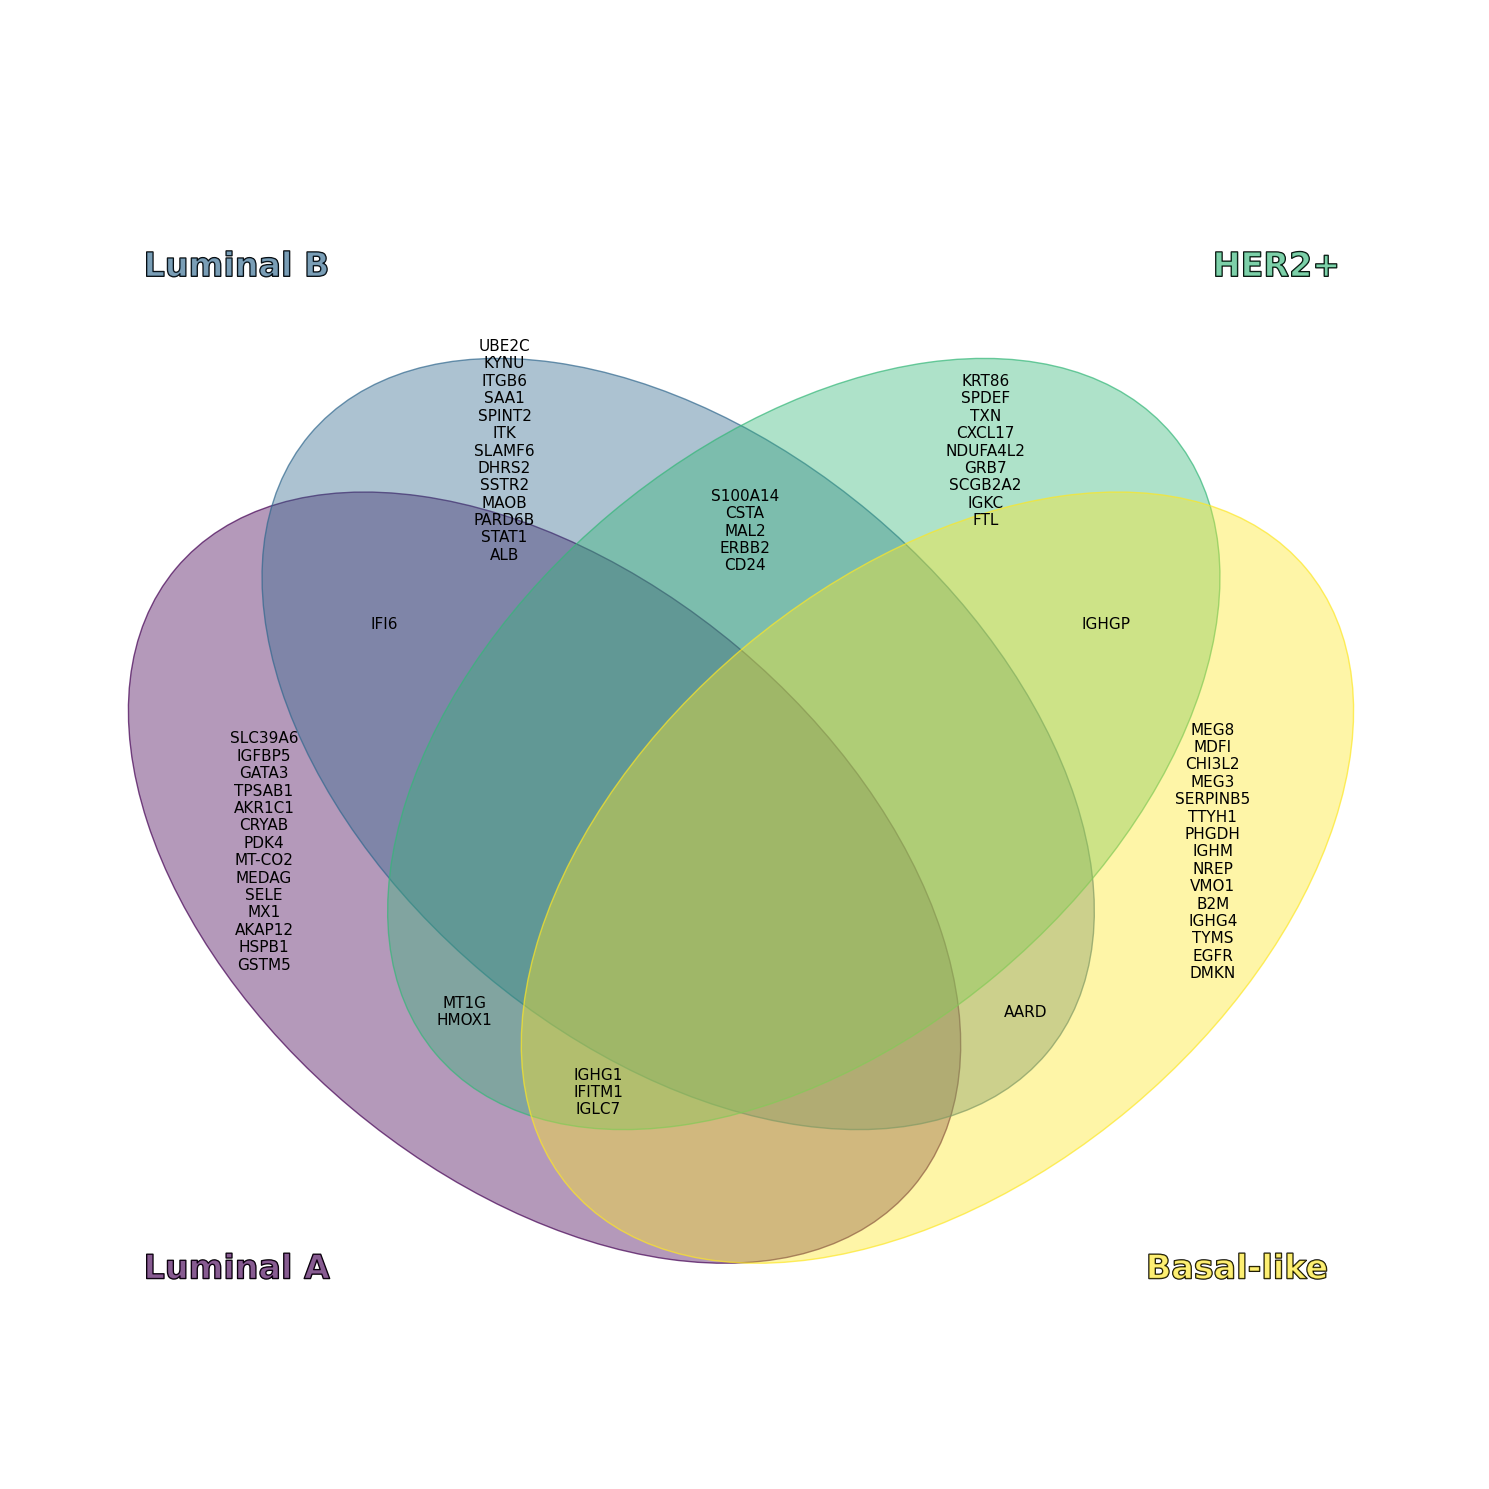

In [9]:
from venn import draw_venn, generate_colors

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
draw_venn(
    petal_labels=intersection_groups_str,
    dataset_labels=["LumA", "LumB", "Her2", "Basal"],
    hint_hidden=True,
    figsize=(15, 15),
    colors=generate_colors(n_colors=4),
    fontsize=11,
    legend_loc="lower right",       
    ax=ax
)
# Hide the legend if it exists
legend = ax.get_legend()
if legend is not None:
    legend.remove()
plt.draw()
# Add custom labels near each petal position

# These positions (x, y) are chosen for a typical 4-set Venn as generated by the venn package.
# You may need to adjust based on the actual drawing.
# These coordinates assume [-1, 1] axes range.

import matplotlib.patheffects as pe
# Bottom left for LumA
colors = generate_colors(n_colors=4)
ax.text(
    0.05, 0.1, "Luminal A",
    fontsize=24,
    fontweight="bold",
    color=colors[0],
    path_effects=[pe.withStroke(linewidth=1, foreground="black")]
)
# Upper left for LumB
ax.text(
    0.05, 0.85, "Luminal B",
    fontsize=24,
    fontweight="bold",
    color=colors[1],
    path_effects=[pe.withStroke(linewidth=1, foreground="black")]
)
# Upper right for Her2
ax.text(
    0.85, 0.85, "HER2+",
    fontsize=24,
    fontweight="bold",
    color=colors[2],
    path_effects=[pe.withStroke(linewidth=1, foreground="black")]
)
# Bottom right for Basal
ax.text(
    0.8, 0.1, "Basal-like",
    fontsize=24,
    fontweight="bold",
    color=colors[3],
    path_effects=[pe.withStroke(linewidth=1, foreground="black")]
)

plt.tight_layout()
plt.savefig("../Outputs/venn_diagram_upregulated.png", dpi=300)
plt.show()
